In [1]:
import writefile_run as writefile_run

In [2]:
%%writefile_run bayeschangept.py

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import datetime as dt

import time
# Importing reader and checker python files as modules
import reader_writer.db_properties as db_props
import reader_writer.writer_configs as write_args
import psycopg2

from utils.preprocessors import *
from utils.data_handler import *
from utils.bayesian_changept_detector import *
import json
from pandas.io.json import json_normalize

import warnings
warnings.filterwarnings('ignore')

rcParams['figure.figsize'] = 12, 9
rcParams[ 'axes.grid']=True

/home/rohithram/anaconda3/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


Use scipy logsumexp().


In [3]:
% matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
# assetno = ['1']
# con = '52.173.76.89:4242'
# src_type =  'opentsdb'
# param = ['FE-001.DRIVEENERGY']
# from_timestamp = 1520402214
# to_timestamp = 1520407294

In [5]:
def preparecsvtoread(filepath):
    df  = pd.read_csv(filepath)
    df['assetno'] = assetno[0]
    df = df.rename(columns={df.columns[0]:'timestamp'})
#     print(df.columns)4
#     print(pd.to_datetime(df['timestamp'],format='%Y'))
    df['timestamp'] = (pd.to_datetime(df['timestamp'],infer_datetime_format=True).astype(np.int64)/(1e6)).astype(np.int64)
    from_timestamp = df['timestamp'].iloc[0]
    to_timestamp = df['timestamp'].iloc[-1]
    metric_names = df.columns[1:-1]
    target_filepath = '.{}-sprint1.csv'.format(filepath.split('.')[1])
    df.to_csv(target_filepath,index=False)
    return target_filepath,from_timestamp,to_timestamp,list(metric_names)

In [6]:
assetno = ['2']
# con = './dataset/methane-input-into-gas-furnace-c.csv'
src_type =  'csv'
# param = ['CO2','Methane']
# from_timestamp = -3147897600000
# to_timestamp = -980985600000

In [7]:
con,from_timestamp,to_timestamp,param = preparecsvtoread('./dataset/alcohol-demand-log-spirits-consu.csv')
print('from_timestamp : {} ,to_timestamp: {}, params: {}'.format(from_timestamp,to_timestamp,param))

from_timestamp : -3147897600000 ,to_timestamp: -980985600000, params: ['Alcohol demand (log spirits consumption per head), UK, 1870-1938']


In [8]:
from_timestamp = -3147897600000
to_timestamp = -980985600000

In [9]:
def call(assetno,from_timestamp,to_timestamp,con,para_list,source_type='opentsdb',table_name='',
        qry_str='',impute_fill_method='forward',down_sampling_method=None,down_sampling_window=None,freq=None,
        resample_fill_method=None,to_resample=None,to_impute=None,thres_prob=0.5,samples_to_wait=10,expected_run_length=100):

        reader_kwargs={
            'assetno':assetno,
            'from_timestamp':from_timestamp,
            'to_timestamp':to_timestamp,
            'con':con,
            'para_list':para_list,
            'source_type':source_type,
            'table_name':table_name,
            'qry_str':qry_str,
            'impute_fill_method':impute_fill_method,
            'down_sampling_method':down_sampling_method,
            'down_sampling_window':down_sampling_window,
            'freq':freq,
            'resample_fill_method':resample_fill_method,
            'to_resample':to_resample,
            'to_impute':to_impute
        }

        algo_kwargs={
            'is_train':False,
            'data_col_index':1,
            'pthres':thres_prob,
            'Nw':samples_to_wait,
            'mean_runlen':expected_run_length
        }
        
        data_reader = Data_reader(reader_kwargs=reader_kwargs)
        
        entire_data = data_reader.read()
        
        writer_data = []
        anomaly_detectors = []
        for i,data_per_asset in enumerate(entire_data):
            assetno = reader_kwargs['assetno'][i]
            data_per_asset[data_per_asset.columns[1:]] = normalise_standardise(data_per_asset[data_per_asset.columns[1:]])

            for data_col in range(1,len(data_per_asset.columns[1:])+1):
                algo_kwargs['data_col_index'] = data_col
                print("\nAnomaly detection for AssetNo : {} , Metric : {}\n ".format(assetno,data_per_asset.columns[data_col]))
                anomaly_detector = Bayesian_Changept_Detector(data_per_asset,assetno=assetno,**algo_kwargs)
                data,anom_indexes = anomaly_detector.detect_anomalies()

                sql_query_args = write_args.writer_kwargs
                table_name = write_args.table_name
                window_size = 10
                
                anomaly_detectors.append(anomaly_detector)
                

        writer = Postgres_Writer(anomaly_detectors,db_credentials=db_props.db_connection,sql_query_args=sql_query_args,
                                table_name=table_name,window_size=window_size)

        writer.map_outputs_and_write()


Data reader initialised 

Getting the dataset from the reader....

Asset no : 2 
                assetno  \
timestamp                
-3.147898e+12      2.0   
-3.137357e+12      2.0   
-3.126816e+12      2.0   
-3.116362e+12      2.0   
-3.105821e+12      2.0   

               Alcohol demand (log spirits consumption per head), UK, 1870-1938  
timestamp                                                                        
-3.147898e+12                                              1.957                 
-3.137357e+12                                              1.979                 
-3.126816e+12                                              2.012                 
-3.116362e+12                                              2.045                 
-3.105821e+12                                              2.056                  


Anomaly detection for AssetNo : 2 , Metric : Alcohol demand (log spirits consumption per head), UK, 1870-1938
 
Shape of the dataset : 
(207, 2)
Overview of f

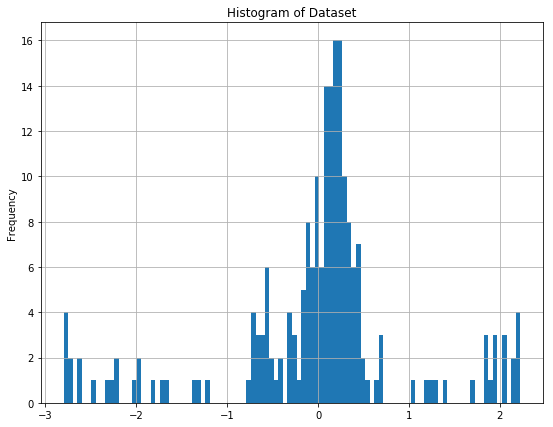

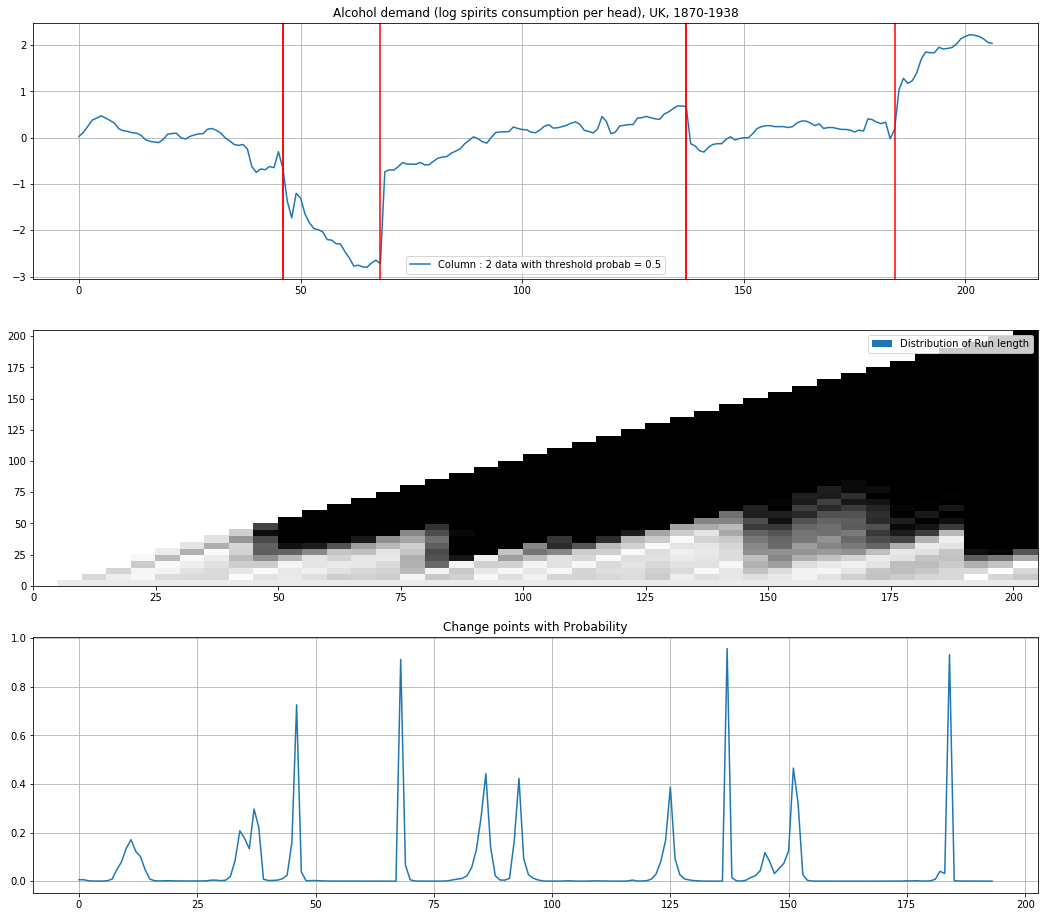


 No of Anomalies detected = 6
Postgres writer initialised 

Assetno : 2 

sql_query: 
[{'operating_unit_serial_number': '2', 'event_type': 'Symptom', 'event_sub_type': 'Anomaly', 'event_source': 'bayesian_change_point_detection', 'event_name': 'Alcohol demand (log spirits consumption per head), UK, 1870-1938_bcp_anomaly', 'event_context_info': '{"body": [{"asset": "2", "readings": [{"name": "Alcohol demand (log spirits consumption per head), UK, 1870-1938", "datapoints": [["\'\'1928-04-01 00:00:00+00:00\'\'", 0.1630261321305827], ["\'\'1928-08-01 00:00:00+00:00\'\'", 0.12289483310450255], ["\'\'1928-12-01 00:00:00+00:00\'\'", 0.1630261321305827], ["\'\'1929-04-01 00:00:00+00:00\'\'", 0.14296048261754263], ["\'\'1929-08-01 00:00:00+00:00\'\'", 0.4078270561896699], ["\'\'1929-12-01 00:00:00+00:00\'\'", 0.38776140667663095], ["\'\'1930-04-01 00:00:00+00:00\'\'", 0.33559071794272766], ["\'\'1930-08-01 00:00:00+00:00\'\'", 0.30348567872186105], ["\'\'1930-12-01 00:00:00+00:00\'\'", 0.33559

In [10]:
# con = './dataset/methane-input-into-gas-furnace-c-sprint1.csv'
kwargs = {
            'assetno':['2'],
            'from_timestamp':from_timestamp,
            'to_timestamp':to_timestamp,
            'con':con,
            'para_list':param,
            'source_type':src_type,
            'table_name':'',
            'qry_str':'',
            'impute_fill_method':'forward',
            'down_sampling_method':None,
            'down_sampling_window':None,
            'freq':None,
            'resample_fill_method':None,
            'to_resample':None,
            'to_impute':True,
            'thres_prob':0.5,
            'samples_to_wait':10,
            'expected_run_length':100
        }

call(**kwargs)

In [11]:
src_type      = 'csv'
filepath      = ''
date_col      = ''
pthres        = 0.01
time_format   = '%Y-%m'
weekly_data   = False
mean_runlen   = 100
Nw            = 10

In [12]:
%%writefile_run bayeschangept.py -a

input_kwargs = {
    'src_type'       :src_type,
    'filepath'      :filepath,
    'date_col'      :date_col,
    'pthres'        :pthres,
    'time_format'   :time_format,
    'weekly_data'   :weekly_data,
    'mean_runlen'   :mean_runlen,
    'Nw'            :Nw
}

In [13]:
%%writefile_run bayeschangept.py -a

input_kwargs['src_type'] = 1
original_data,anom_indexes = analyse_detectchangepts(**input_kwargs)

NameError: name 'analyse_detectchangepts' is not defined

In [14]:
original_data,anom_indexes = analyse_detectchangepts(src_type=0,filepath="./alcohol-demand-log-spirits-consu.csv",date_col='Month',
                                                     pthres=0.5)

NameError: name 'analyse_detectchangepts' is not defined

In [ ]:
temp_data,anom_indexes = analyse_detectchangepts(src_type=0,filepath="./average-annual-temperature-centr.csv",date_col='Year'
                                         ,pthres=0.4,time_format='%Y')

plt.plot(temp_data[0:200])
plt.show()

In [ ]:
fisher_tempdata = analyse_detectchangepts(src_type=0,filepath="./mean-daily-temperature-fisher-ri.csv",
                                         date_col='Date',time_format='%d-%m-%Y',pthres=0.7)

In [ ]:
female_unemp_data = analyse_detectchangepts(src_type=0,filepath="./monthly-us-female-20-years-and-o.csv",
                                         date_col='Month',time_format='%Y-%m',pthres=0.4)

In [ ]:
weekly_close_data = analyse_detectchangepts(src_type=0,filepath="./weekly-closings-of-the-dowjones-.csv",
                                         date_col='Week',time_format='%Y-W%W-%w',weekly_data=True,pthres=0.3)

In [ ]:
weekly_close_data = analyse_detectchangepts(src_type=0,filepath="methane-input-into-gas-furnace-c.csv",ncol=0,
                                         date_col='Time',pthres=0.4)

In [ ]:
weekly_close_data2 = analyse_detectchangepts(src_type=0,filepath="methane-input-into-gas-furnace-c.csv",ncol=1,
                                         date_col='Time',pthres=0.4)

In [ ]:
mean_tempdata = analyse_detectchangepts(src_type=0,filepath="./mean-monthly-temperature-1907-19.csv",
                                        date_col='Month',time_format='%Y-%m')

# Conclusion:
* Hence we observe that **Bayesian Changepoint Detection** works well only on level shifts or variational shift datasets over outlier or surge,sag datasets